<a href="https://colab.research.google.com/github/mode1990/Tensorflow-VAE-multimodal-test/blob/main/VAE_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Generate synthetic data
n_cells = 100
n_genes = 1000
n_peaks = 5000
n_features = 500

scrnaseq_data = np.random.negative_binomial(n=5, p=0.3, size=(n_cells, n_genes))
scatacseq_data = np.random.binomial(n=1, p=0.1, size=(n_cells, n_peaks))
cell_painting_data = np.random.normal(loc=0, scale=1, size=(n_cells, n_features))
labels = np.random.randint(0, 2, size=(n_cells,))
labels = labels.reshape(-1, 1)

# Combine all datasets
combined_data = np.concatenate([scrnaseq_data, scatacseq_data, cell_painting_data], axis=1)

# Normalize the data
combined_data = (combined_data - np.mean(combined_data, axis=0)) / np.std(combined_data, axis=0)

# Define VAE architecture
latent_dim = 32
input_dim = combined_data.shape[1]

class VAEClassifier(keras.Model):
    def __init__(self, input_dim, latent_dim):
        super(VAEClassifier, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        self.classifier = self.build_classifier()

    def build_encoder(self):
        inputs = keras.Input(shape=(self.input_dim,))
        x = keras.layers.Dense(256, activation="relu")(inputs)
        x = keras.layers.Dense(128, activation="relu")(x)
        z_mean = keras.layers.Dense(self.latent_dim)(x)
        z_log_var = keras.layers.Dense(self.latent_dim)(x)
        return keras.Model(inputs, [z_mean, z_log_var], name="encoder")

    def build_decoder(self):
        inputs = keras.Input(shape=(self.latent_dim,))
        x = keras.layers.Dense(128, activation="relu")(inputs)
        x = keras.layers.Dense(256, activation="relu")(x)
        outputs = keras.layers.Dense(self.input_dim)(x)
        return keras.Model(inputs, outputs, name="decoder")

    def reparameterize(self, z_mean, z_log_var):
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def build_classifier(self):
        inputs = keras.Input(shape=(self.latent_dim,))
        x = keras.layers.Dense(64, activation="relu")(inputs)
        x = keras.layers.Dense(32, activation="relu")(x)
        outputs = keras.layers.Dense(1)(x)  # No activation for logits
        return keras.Model(inputs, outputs, name="classifier")

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decoder(z)
        classified = self.classifier(z)
        return reconstructed, z_mean, z_log_var, classified

def vae_classifier_loss(model, x, y):
    x_reconstructed, z_mean, z_log_var, y_pred = model(x)
    reconstruction_loss = tf.reduce_mean(keras.losses.mse(x, x_reconstructed))
    kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))

    # Convert labels to float32
    y = tf.cast(y, tf.float32)

    # Compute classification loss
    classification_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_pred))

    return reconstruction_loss + kl_loss + classification_loss

# Create VAE model with classifier
vae_classifier = VAEClassifier(input_dim, latent_dim)

# Compile the model
vae_classifier.compile(optimizer=keras.optimizers.Adam())

# Custom training loop
@tf.function
def train_step(model, x, y, optimizer):
    with tf.GradientTape() as tape:
        loss = vae_classifier_loss(model, x, y)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Training loop
epochs = 50
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((combined_data, labels)).shuffle(1000).batch(batch_size)

for epoch in range(epochs):
    total_loss = 0
    num_batches = 0
    for batch_x, batch_y in train_dataset:
        loss = train_step(vae_classifier, batch_x, batch_y, vae_classifier.optimizer)
        total_loss += loss
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{epochs}, Loss: {average_loss:.4f}")

# Evaluate the model
latent_representations, _, _, predictions = vae_classifier(combined_data)

# Convert predictions to binary classes
binary_predictions = tf.round(tf.sigmoid(predictions))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(tf.equal(binary_predictions, labels), tf.float32))
print(f"Accuracy: {accuracy:.4f}")




Epoch 1/50, Loss: 2.5593
Epoch 2/50, Loss: 2.9172
Epoch 3/50, Loss: 2.2663
Epoch 4/50, Loss: 2.1558
Epoch 5/50, Loss: 1.8939
Epoch 6/50, Loss: 1.7439
Epoch 7/50, Loss: 1.7631
Epoch 8/50, Loss: 1.6366
Epoch 9/50, Loss: 1.5033
Epoch 10/50, Loss: 1.5467
Epoch 11/50, Loss: 1.5394
Epoch 12/50, Loss: 1.4812
Epoch 13/50, Loss: 1.5356
Epoch 14/50, Loss: 1.5358
Epoch 15/50, Loss: 1.4641
Epoch 16/50, Loss: 1.5407
Epoch 17/50, Loss: 1.5810
Epoch 18/50, Loss: 1.4523
Epoch 19/50, Loss: 1.5498
Epoch 20/50, Loss: 1.4922
Epoch 21/50, Loss: 1.8924
Epoch 22/50, Loss: 1.5693
Epoch 23/50, Loss: 1.5666
Epoch 24/50, Loss: 1.5817
Epoch 25/50, Loss: 1.7125
Epoch 26/50, Loss: 1.4922
Epoch 27/50, Loss: 1.5638
Epoch 28/50, Loss: 1.4071
Epoch 29/50, Loss: 1.5320
Epoch 30/50, Loss: 1.5952
Epoch 31/50, Loss: 1.6784
Epoch 32/50, Loss: 1.4322
Epoch 33/50, Loss: 1.6299
Epoch 34/50, Loss: 1.5692
Epoch 35/50, Loss: 1.3771
Epoch 36/50, Loss: 1.3806
Epoch 37/50, Loss: 1.4997
Epoch 38/50, Loss: 1.4469
Epoch 39/50, Loss: 1.

In [13]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 19.7 MB/s eta 0:00:00


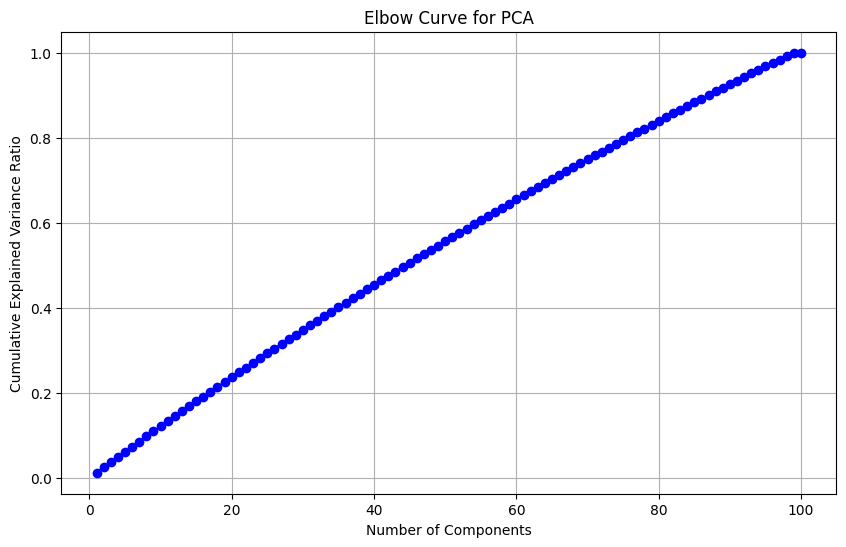

Elbow point (90% explained variance): 87


  0%|          | 0/100 [00:00<?, ?it/s]

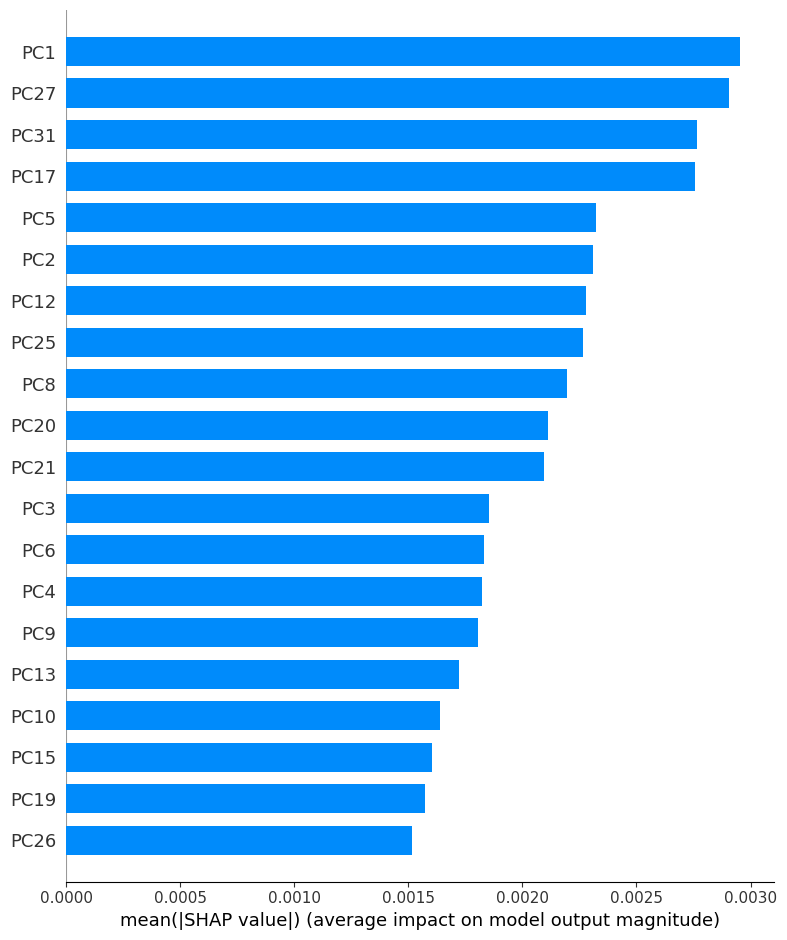

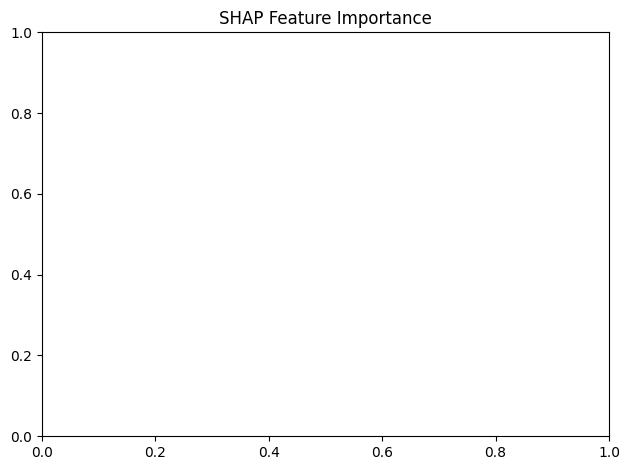

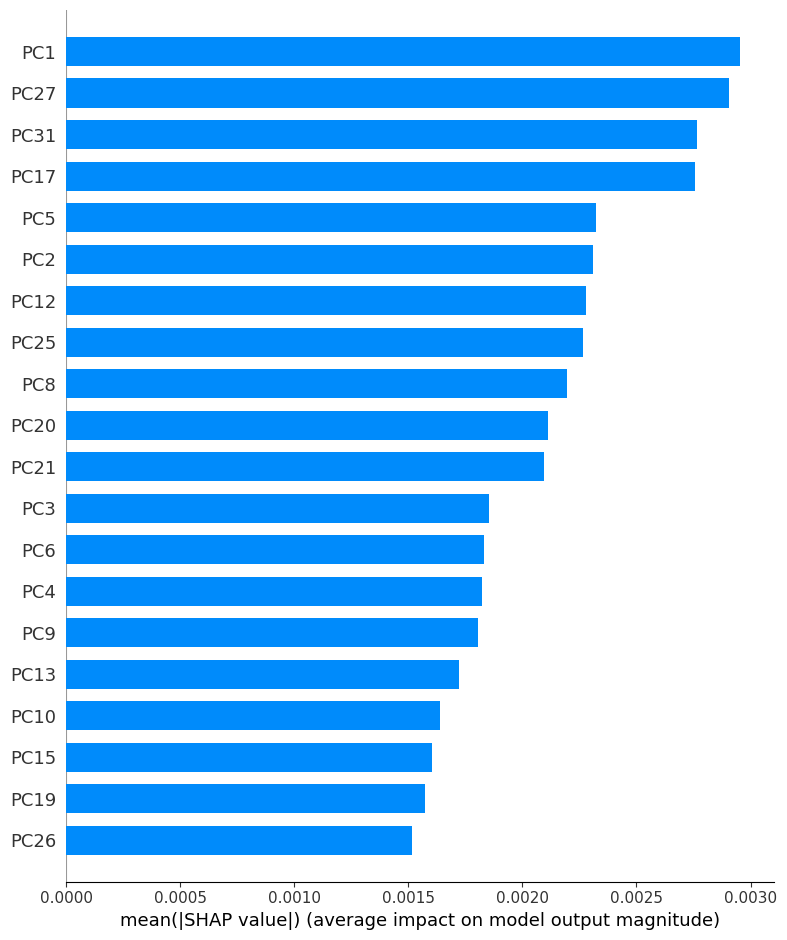

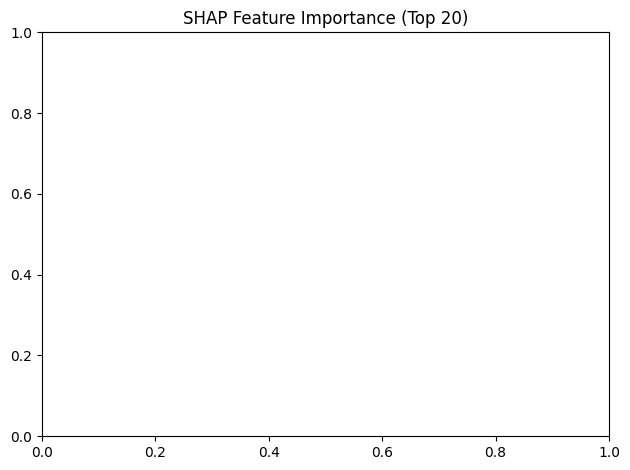

<Figure size 1000x600 with 0 Axes>

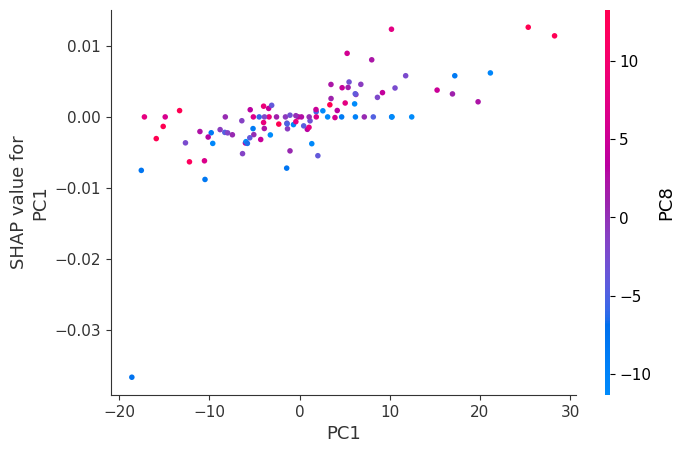

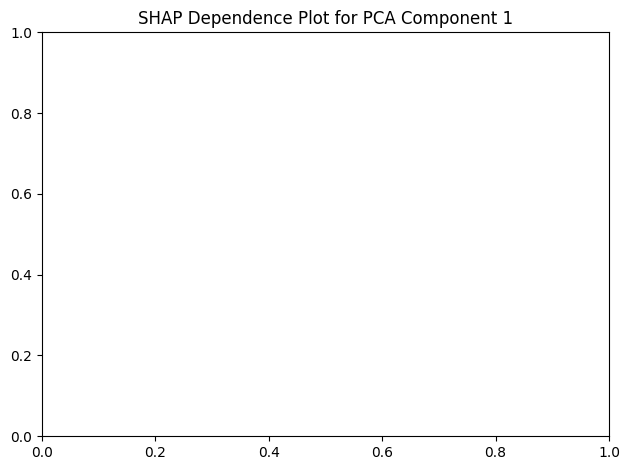

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import shap
from sklearn.ensemble import RandomForestRegressor

# Assuming we have our combined_data

# 1. Perform PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(combined_data)

pca = PCA()
pca_results = pca.fit_transform(scaled_data)

# 2. Implement the elbow method for PCA
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Elbow Curve for PCA')
plt.grid(True)
plt.show()

# Find the elbow point (you may need to adjust this based on the plot)
elbow_point = np.argmax(cumulative_variance_ratio > 0.9) + 1
print(f"Elbow point (90% explained variance): {elbow_point}")

# 3. Calculate and visualize SHAP features
# We'll use the top PCA components to predict a subset of the original features

n_components = min(32, elbow_point)  # Use either 32 or the elbow point, whichever is smaller
top_pca_components = pca_results[:, :n_components]

# Select a subset of original features (e.g., first 100) for SHAP analysis
n_features_for_shap = 100
subset_features = combined_data[:, :n_features_for_shap]

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(top_pca_components, subset_features)

# Define a function to predict the mean output across all features
def f(X):
    return rf_model.predict(X).mean(axis=1)

# Use KernelExplainer
explainer = shap.KernelExplainer(f, top_pca_components)
shap_values = explainer.shap_values(top_pca_components, nsamples=100)  # Adjust nsamples as needed

# Plot SHAP summary
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, top_pca_components, plot_type="bar", feature_names=[f"PC{i+1}" for i in range(n_components)])
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

# Plot SHAP summary for the top 20 features
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, top_pca_components, plot_type="bar", feature_names=[f"PC{i+1}" for i in range(n_components)], max_display=20)
plt.title("SHAP Feature Importance (Top 20)")
plt.tight_layout()
plt.show()

# SHAP dependence plot for the most important feature
feature_importance = np.abs(shap_values).mean(axis=0)
most_important_feature = feature_importance.argmax()
plt.figure(figsize=(10, 6))
shap.dependence_plot(most_important_feature, shap_values, top_pca_components, feature_names=[f"PC{i+1}" for i in range(n_components)])
plt.title(f"SHAP Dependence Plot for PCA Component {most_important_feature+1}")
plt.tight_layout()
plt.show()